# **Molecular Representation and Conversion Methods**
**Date:** May 2025  
**Contact:** github.com/ckross4

From a mathematical standpoint, molecules are a heterogenous, non-directional, non-eulerian graphs. The atoms are the vertices (nodes) and the chemical bonds are the edges. There are many ways to represent this set of atoms and bonds, but ultimately the best method will depend on several factors. Each method has its own trade-offs in terms of interpretability, information content, and computational efficiency. Before choosing a ***molecular representation method*** **(MRM)**, you should consider the following three things:
##### 1. **Size of your dataset** 
- For small datasets (e.g., a few molecules), simple schemes like arbitrary numbering (1, 2, 3…) or one-hot encoding may be sufficient. However, for datasets containing thousands of molecules, we need to consider more efficient representations that offer both compression and specificity.
##### 2. **Molecular Variance and Diversity**
- Molecular variance can arise from differences in elements, isomerism, bonding patterns, chirality, conformation, crystal structure, tautomerism, molecular weight, and many other features. It is important that the MRM you choose is capable of focusing on attributes of your dataset with high variance.
##### 3. **Model Choice**
- Your model architecture should be capable of capturing the molecular variance present in your dataset. Think of your model as a microscope scanning over your database — if it's too "zoomed in" on certain features or too "zoomed out" on others, it may struggle to differentiate molecules of the dataset.

MRMs can range from highly systematic to completely arbitrary. Comprehensive representation can showcase the details of your dataset with high fidelity, but partial representation can sometimes highlight hidden factors. Below is a listing of the most common MRMs with their advantages and disadvantages.

| Representation Method| Examples | Advantage | Disadvantage | Use case |
|----------------------|----------|-----------|--------------|----------|
|Linear notation     |SMILES, BigSMILES, InCHI| Readable, single line notation, highly compact, low memory consumption, easily converted to other representation methods  | 1-D representation loses some fidelity, no support for more complex structures, variable length | General molecular datasets, precursor before converting to other representations |
| Fingerprinting (Dictionary-style) | MACCSKeys, PubChemFP, QSPR | Fixed length vectors, human readable, key and value system highlight variance | Low resolution, non-specific, highly subjective, not good for dataset where molecules have high structural similarity | Molecular datasets with very large chemical variance |
| Fingerprinting (Hash-style) | MorganFP, RDKitFP  | Fixed length vectors, highly specific, objective, low bit collision, low memory requirement, good molecular comparison | Not human readable, bits have semi-arbitrary meaning, mostly 2-D based | Good for most cases, many existing comparison studies |
| Graph | Molecular Graph | Explicit representation of molecule, atom features and bond features, 3-D support| Highly sparse, not compatible with other models, higher memory requirement | Graph neural networks |

This a small list of categories of MRMs. In reality, any method that accurately captures the variance of your molecules while retaining good specificity is a viable representation. Below is a simple compass showing a comparison of MRMs based on interpretability and abstraction. 

<p align="center">
  <img src="InterpretabilityvsAbstraction.png" alt="Description" width="800"/>
</p>


This notebook will guide you through several common MRMs and how to prepare them for your machine learning experiments.
If you would like to run this code yourself, make sure uncomment and install the required dependencies below.

In [ ]:
# pip install -r requirements.txt

# [**SMILES**](https://www.daylight.com/dayhtml/doc/theory/theory.smiles.html)

SMILES (Simplified Molecular Input Line Entry System) was created in the 1980's by David Weininger. The SMILES notation is a moderately robust notation for chemical representation. SMILES does have its own file extension (`.smi`), but SMILES strings are so compact that is very easy to represent molecules with a short string. A full set of rules for writing SMILES notation can be found [here](https://chem.libretexts.org/Courses/Fordham_University/Chem1102%3A_Drug_Discovery_-_From_the_Laboratory_to_the_Clinic/05%3A_Organic_Molecules/5.08%3A_Line_Notation_(SMILES_and_InChI)). Most notably, hydrogen atoms are not included in the notation unless explicitly stated. Listed below are several examples of IUPAC names, SMILES strings, and structure diagrams.

Additionally, due to the limitations of SMILES, there are several improved linear notation systems


- [SMARTS (SMILES ARbitrary Target Specification)](https://www.daylight.com/dayhtml/doc/theory/theory.smarts.html): Generalized SMILES notation to represent substructures, normally used for substructure searching
- [SMIRKS](https://www.daylight.com/dayhtml/doc/theory/theory.smirks.html): SMILES based notation for reactions
- [BigSMILES](https://olsenlabmit.github.io/BigSMILES/docs/line_notation.html#the-bigsmiles-line-notation): Improved notation for heteropolymers


SMILES is a minimalist, compressed expression of the molecule, making it a top choice for data storage. However, SMILES as a linear notation system struggles to capture 3-D structure, tautomerism, coordination, and polymers. For homopolymers, the representation can be modified by including `*` to represent the bonding points between monomers. There are several workarounds for the issues listed above, but if they are not a core quality of your dataset, you can generally get by without incorporating them.

Since most datasets already use some form of linear notation to store their molecules, this portion of code will show you how to use PubChem PUG REST API to get your chemical's SMILE notation as well as some other useful notations. This example uses the chemical dopamine.

In [36]:
import requests
from requests.exceptions import ConnectionError

def get_props(chemical_name: str, database:str = 'Compound'):
    '''
    Returns dictionary of properties for a given chemical name using PubChem API.

    Args: 
        chemical_name: str
            The name of the chemical compound to search for.
        database: str, optional
            The PubChem database to query. Can be 'Compound' or 'Substance'. Default is 'Compound'.
            
    Note: 'Substance' listings in PubChem are less standardized and may contain inaccurate information.
    '''
    try:
        url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/{database}/name/{chemical_name}/record/JSON"
        response = requests.get(url)
        if response.status_code == 200:
            response = response.json()
            props_dict = {}
            for item in response['PC_Compounds'][0]['props']:
                label = item['urn']['label']
                if 'name' in item['urn'].keys():
                    label = f"{item['urn']['name']} {label}"
                else:
                    label = label
                value = list(item['value'].values())[0]
                props_dict[label] = value
            return props_dict
        else:
            response = response.json()
            print(f"Error: {response['Fault']['Message']}, {response['Fault']['Details'][0]}")
            return None
    except ConnectionError:
        print("You are not connected to the internet, please check your connection and try again.")

In [37]:
mol_prop_dict = get_props('dopamine')
mol_prop_dict

{'Canonicalized Compound': 1,
 'Compound Complexity': 119,
 'Hydrogen Bond Acceptor Count': 3,
 'Hydrogen Bond Donor Count': 3,
 'Rotatable Bond Count': 2,
 'SubStructure Keys Fingerprint': '00000371C0723000000000000000000000000000000000000000300000000000000000010000001E00100800000C04C1980430068040020080022042000002000020200008888006888809262282911380700124D01109980790D0B00E20000100000040004000020000008000000000000000',
 'Allowed IUPAC Name': '4-(2-aminoethyl)benzene-1,2-diol',
 'CAS-like Style IUPAC Name': '4-(2-aminoethyl)benzene-1,2-diol',
 'Markup IUPAC Name': '4-(2-aminoethyl)benzene-1,2-diol',
 'Preferred IUPAC Name': '4-(2-aminoethyl)benzene-1,2-diol',
 'Systematic IUPAC Name': '4-(2-azanylethyl)benzene-1,2-diol',
 'Traditional IUPAC Name': '4-(2-aminoethyl)pyrocatechol',
 'Standard InChI': 'InChI=1S/C8H11NO2/c9-4-3-6-1-2-7(10)8(11)5-6/h1-2,5,10-11H,3-4,9H2',
 'Standard InChIKey': 'VYFYYTLLBUKUHU-UHFFFAOYSA-N',
 'XLogP3 Log P': -1,
 'Exact Mass': '153.078978594',
 'Molecular For

The above dictionary `mol_prop_dict` contains a myriad of identifiers you can use for your machine learning projects. You can also explore the `response` variable in the above function for some additional properties. The API also offers more complex search methods such as by substructure. You can learn more about searching PubChem's API [here](https://pubchem.ncbi.nlm.nih.gov/docs/pug-rest-tutorial). 

I would like to leave a few very IMPORTANT warnings about trawling through databases using API's.

1. Short term rate limits
- Most databases have a short term (1s, 5s...) call request limit to prevent users overloading the system. The call limit for PubChem is 5 calls/second. If you are running a for-loop and you find that the API is constantly returning 404 errors, you may want to add a delay to your loop (`time.sleep()`).

2. Long term rate limits
- Some databases have a long term call request limit(1hr, 24hrs...). If you need to collect a large amount of data, make sure to plan accordingly, incorporate fail safes (`try-except` blocks), and preprocess your data to avoid unnecessary and duplicate calls. Please respect these limits, they are there for the safety of the server and the sustainability of public resources.

3. Most importantly, make sure to ***check the response matches your search content***. Large chemical databases often contain mislabeled records. In PubChem, a chemical entry is first recorded as a substance, which reflects a community-contributed or submission. After undergoing standardization and deduplication, it may then be elevated to a compound, which represents a chemical structure aggregated from multiple substance records. As a result, you may encounter cases where your chemical exists in the substance database but not the compound database. You can tweak the code above to search through substances but beware your response may contain inaccurate information.

# [**BigSMILES**](https://olsenlabmit.github.io/BigSMILES/docs/line_notation.html#the-bigsmiles-line-notation)

Due to the complex geometry of heteropolymers, representation of heteropolymers in SMILES is extremely limited. BigSMILES greatly improves heteropolymer representation and multifunctional monomers (more than 2 bonding points) using a modified bonding system. In SMILES notation, a bonding point can be represented by `*`, which causes several shortcomings.
- `*CC*` and `*CCCC*` while chemically identical, would be represented as two different structures
- For copolymers, only alternating copolymers can be realistically represented (`*AB*`), random and block copolymer samples with different lengths would count as different molecules (`*AABB*` and `*AABBAABB*`)
- Multifunctional monomers could be represented by multiple bonding points (`*C*CC*`), but the implication is that a bonding between any two points is equally likely. Generally, copolymers do not bond 100% randomly, reactivity rates between functional groups have a large influence on the final product.
- No support for more complex architectures such as branched or grafted copolymers

Within BigSMILES, a polymer can be written using a stochastic object with repeating units and bonding descriptors.
### **Bonding Descriptors**
- `$` represents possible connections to any other unit with `$` type descriptor
- `<` and `>` represent connective patterns where the units can only bond in a specific conjugation ie polycondensation

### **Stochastic Object**
An object containing the **repeat units** and **end groups**
- `{` and `}` enclose the inner components
- Repeating units separated by `,`
    - Units must have bonding descriptors
- End groups separated by `;`
    - Explicit: Terminal end groups are written as a small SMILES string with single bond descriptor ***outside*** of stochastic object, useful when end caps are known.
    - Implicit: End groups are written ***within*** stochastic object with single bond descriptor, useful when many possible end cap configurations are possible ie dendrimer.

There are currently two public packages for creating BigSMILES notation, [`gbigsmiles`](https://pypi.org/project/gbigsmiles/) and [BigSMILES_homopolymer](https://github.com/CDAL-SChoi/BigSMILES_homopolymer/tree/main). Both of these packages are powerful tools that offer a lot of flexibility to convert structures to BigSMILES strings. However, both of them require a much deeper understanding of the notation than this notebook will go into. You can check their packages and examples if you would like to use them in your projects.

# **[InChi and InChiKey](https://www.inchi-trust.org/)**

Originally a chemical database registry notation, InChi (International Chemical Identifier) is a semi human-readable structure-based fingerprint. Developed by IUPAC (International Union of Pure and Applied Chemistry), InChi was initially created to apply to the entire domain of organic chemistry (structure focus), and eventually all chemistry. A molecule’s InChi is built in layers. After the prefix ‘Inchi=1S/’ to denote InChi Standard, the empirical formula for the molecule is included and each subsequent layer is separated with ‘/’ and an identifying letter. There are six total layers of InChi.
- Chemical formula
- Charge
- Stereochemical
- Isotopic
- Fixed-H
- Reconnected layer

Due to the exhaustive algorithm that encodes a molecule’s structural information, the resulting InChI string can be hundreds of characters long. Its verbosity poses challenges for indexing, web searching, and database optimization. To address this, the InChIKey was introduced as a compact, fixed-length hashed version of the full InChI. Each InChIKey consists of 27 characters, divided into three blocks, and is specifically designed for use in web-based searches and efficient lookup operations. The InChIKey is generated using a SHA-256 hash function. This process is non-reversible and the original InChI string cannot be built from an InChIKey. 

We have already seen how to get properties and identifiers using PubChem's API, lets compare it with a `mol` object from RDKit to make sure we have the correct molecule from the database.

In [ ]:
from rdkit import Chem

pc_inchi = mol_prop_dict['Standard InChI']
pc_inchi_key = mol_prop_dict['Standard InChIKey']

my_mol = Chem.MolFromSmiles(mol_prop_dict['Canonical SMILES'])

rd_inchi = Chem.MolToInchi(my_mol)
rd_inchi_key = Chem.MolToInchiKey(my_mol)

print(True if pc_inchi == rd_inchi and pc_inchi_key == rd_inchi_key else False)
print(f"InChi: {pc_inchi}\nInChIKey: {pc_inchi_key}")

True
InChi: InChI=1S/C8H11NO2/c9-4-3-6-1-2-7(10)8(11)5-6/h1-2,5,10-11H,3-4,9H2
InChIKey: VYFYYTLLBUKUHU-UHFFFAOYSA-N


# **Molecular Fingerprints**
Molecular fingerprints (MFs) are a widely used method for converting a molecule into a fixed-length, bit vector. Compared to molecular graphs, molecular fingerprints give a more ***abstract representation*** of the molecule. This means that model does not receive the full structural representation of the molecule, but instead receives a projection of the molecule. You can imagine this like looking at a map of the world. We know the Earth is round, but we **project** it to a flat map for ease of use and readability. There are two main types of MFs.
 - Dictionary: These fingerprints use a key-value method to store information. Each key represents some property of the molecule. Some of these fingerprints were originally designed to be used in databases as ways of sorting or searching for molecules. Overall, they are used less frequently due to their subjective nature, but they are very fast when comparing molecular similarity. Not all properties of a molecule can be contained in the fingerprint, and some features may be over or underemphasized. The example used in this notebook is MACCS Keys, with 166 features.
 - Hashed: Hashed fingerprints use a bit map to encode the molecule to fixed length bit vector (1024, 2048 bits...). Each bit represents some portion of the molecule but does not have a fixed meaning. This style of fingerprinting is generally preferred due to its objectivity in describing molecules. This notebook will use morgan fingerprints and show some representations of the bits.

Let's take a look at MACCS Keys, a popular set of 166 predefined structural keys used for molecular fingerprinting. This notebook includes a CSV file containing the list of all 166 MACCS Keys. Make sure the CSV file is located in the same directory as this notebook, or update the file path accordingly. Note that the first bit, labeled 'placeholder', is included to align the bit indices with conventional MACCS indexing, which starts from 1, whereas Python indexing starts from 0. This ensures consistency between the key positions in the fingerprint and their corresponding definitions.

In [39]:
from rdkit.Chem import MACCSkeys
import pandas

keys = pandas.read_csv('MACCS.csv', header=None)
maccs_fp = MACCSkeys._pyGenMACCSKeys(my_mol).ToList()

# Look through the 'on' bits
for i, bit in enumerate(maccs_fp):
    if bit == 1:
        print(keys.iloc[i][0])

QH 3 bonds from another QH
O separated by 3 bonds
Heteratoms attached to a CH2
NH2 groups
Het. 4 bonds from a CH2
N attached to CH2
Hets. 2 bonds from a CH2
N 2 bonds from a CH2
O in non-aromatic bonds to an [a]
Key(147)-1 if key(147)>1; else 0
Key(143)-1 if key(143)>1; else 0
Het atoms with H
OH groups
Non ring O connected to a ring
Atoms separated by (!:):(!:)
CH2 attached to CH2
X separated by (!r)-r-(!r)
NH
C bonded to >=2 C and 1 O
Non-carbons attached to CH2
Non-ring CH2
O in C-O single bonds
N in C-N single bonds
Key(164)-1 if key(164)>1; else 0
N
Aromatics
Atoms in 6 rings
Oxygens
Ring atoms


# [**Morgan Fingerprints**](https://pubs.acs.org/doi/10.1021/ci100050t)

By far, the most commonly investigated chemical fingerprint is Morgan fingerprints, also known as the Extended-Connectivity Fingerprint (ECFP). Morgan fingerprints are a hashed, circular fingerprint, breaking the molecule into substructures. By design, Morgan fingerprints do not require canonical atom numbering. The algorithm for Morgan fingerprints consists of four steps: 
1. Each atom in the molecule is assigned an initial identifier. The atom ordering is based on connectivity and position.
2. Information from its neighboring atoms is aggregated, in a process similar to message passing.
3. The aggregated information is hashed into a new integer, and each atom’s identifier is updated. This process is repeated a specified number of times, and fingerprint depth can be adjusted by setting the number of iterations.
4. Duplicate structures are removed, and the remaining set of structures is mapped into a binary vector. As a binary vector, the count of removed duplicates is not retained, but this redundant information can be preserved separately if needed.

Let's take a look at the bit vector of our `mol` object and what each bit represents.

In [ ]:
from rdkit.Chem import AllChem

fp_gen = AllChem.GetMorganGenerator(2)
ao = AllChem.AdditionalOutput()
ao.CollectBitInfoMap()
morgan_fp = fp_gen.GetFingerprint(my_mol, additionalOutput=ao)
print(morgan_fp.ToBitString())
print(f"Sparsity: {100 * morgan_fp.GetNumOffBits()/morgan_fp.GetNumBits():.3f}%")

0000000000000000000000000000000000000000000000000000000000000000000000000000000010000000000000000000000010000000000000000000000000000000000000000000000000000000000000000000000000000000000000000100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000100001000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001000000000000000000000000000000000000000000000000000000000000000000010000000000000000000000000000000000000000000000000000000000000100000000000000000000000000000000000000000001000000000000000000

Looking at the bit string above, we can see that Morgan fingerprints are a very sparse fingerprinting method. If you find your model struggling to learn, you can investigate other methods such as converting to a sparse matrix or using a hashed method. Let's take a look at the bits and see what each bit represents.

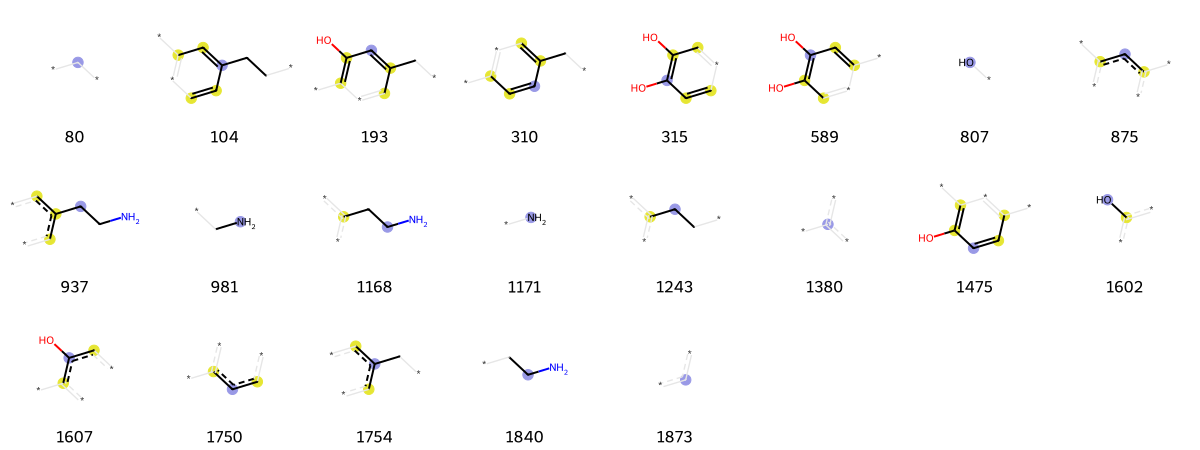

In [ ]:
from rdkit.Chem import AllChem
import rdkit.Chem.Draw as Draw

fp_gen = AllChem.GetMorganGenerator(2)
ao = AllChem.AdditionalOutput()
ao.CollectBitInfoMap()
morgan_fp = fp_gen.GetFingerprint(my_mol, additionalOutput=ao)
bi = ao.GetBitInfoMap()
bits = morgan_fp.GetOnBits()
morgan_bits = []
bit_nums = []

for bit in bits:
    morgan_bits += [(my_mol, bit, bi)]
    bit_nums += [str(bit)]
Draw.DrawMorganBits(morgan_bits, molsPerRow=8,legends=bit_nums)

Each bit is mapped to a specific fragment of the molecule. As you model learns, it is attributing properties of your molecule to substructures and groups of substructures. 

# [**Molecular Graphs**](https://pytorch-geometric.readthedocs.io/en/latest/)

Molecular graphs are an effective way to represent both the chemical and structural diversity of molecules. Their core strength is they provide an ***comprehensive representation*** of the molecule. The model receives all the atoms, bonds, and their connections. They consist of two key matrices: a **feature matrix**, which contains the attributes of each node (atom), and an **adjacency matrix**, which encodes the pairs of nodes that form edges (bonds). These matrices are critical for graph convolutional neural networks (GCNs or GNNs), where they are multiplied together during ***message passing*** before the forward pass. Before diving deeper into GCNs and how the information in a molecular graph is processed, let's first focus on how to represent a molecule as a graph.

A molecular graph object contains the following data:

| Component         | Description |
|-------------------|-------------|
| Node features     | Attributes of each atom (atomic weight, charge, degree...) |
| Edge features     | Attributes of each bond (bond type, stereochemistry...) |
| Edge index        | Atom pairings; a more compact method for storing connectivity than a full adjacency matrix |
| Target (Y-value)  | The property to be predicted by the machine learning model (for supervised learning tasks) |


<p align="center">
  <img src="MessagePassingPPT.png" alt="Description" width="800"/>
</p>


In this example, we will convert a `SMILES` string into PyG data object. Our molecule is already canonical, but if you are drawing structures and converting them to `mol` objects, you may want to use RDKit to canonicalize your structure first. 

In [43]:
from deepchem.feat import MolGraphConvFeaturizer

featurizer = MolGraphConvFeaturizer(use_edges=True)
my_graph = featurizer(my_mol)[0]
my_graph

GraphData(node_features=[11, 30], edge_index=[2, 22], edge_features=[22, 11])

Excellent, we can see the information of our molecule is now stored in a `GraphData` object provided by DeepChem. This featurizer provides 30 node features and 11 edge features. For a detailed list of features, you can check out the DeepChem documentation [here](https://deepchem.readthedocs.io/en/latest/api_reference/featurizers.html#molgraphconvfeaturizer). You might notice that although we have 11 nodes, we have 22 edges. Let's inspect the first node, first edge, and the edge index of our data object to get an idea of how our molecule is represented. 

In [34]:
atom_idx = 0
print(f"Node feat '{my_mol.GetAtomWithIdx(atom_idx).GetSymbol()}': {my_graph.node_features[atom_idx]}")
print(f"Edge feat'{my_mol.GetAtomWithIdx(atom_idx).GetSymbol()}-{my_mol.GetAtomWithIdx(atom_idx+1).GetSymbol()}': {my_graph.edge_features[atom_idx]}")
print(f"Edge index: \n{my_graph.edge_index}")

Node feat 'C': [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0.
 0. 1. 0. 0. 0. 0.]
Edge feat'C-C': [0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0.]
Edge index: 
[[ 0  1  1  2  2  3  3  4  4  5  5  6  6  7  7  8  3  9  2 10  5  0]
 [ 1  0  2  1  3  2  4  3  5  4  6  5  7  6  8  7  9  3 10  2  0  5]]


Here we can see what the model is learning from. For dopamine, the first atom is carbon, represented by a bit in the first position of the node features.

Looking at the edge index, we can see why it is double the length of the number of bonds. Each bond is saved twice to preserve non-directionality. As previously stated, this is a much more compact method of storing our adjacency matrix. If we used a full normalized adjacency matrix, we would need a N * N matrix (containing mostly zero's) to represent our molecule.

DeepChem (and other repositories) have many different featurizers to choose from. Before using a featurizer, take note of the dependencies required. If the dependent packages aren't installed, your featurizer may return an empty array (sometimes with no warning!).

This data object will work for models from deepchem, but we might start hitting some errors when we try to use this object with other packages. Let's convert our `GraphData` object into a `Data` object using pytorch geometric. This will save us issues later if we have large sets of molecules we want to batch together. Additionally, the pyg `Data` object will allow us to save additional information. Graph-level attributes can store additional properties of a molecule, including those with mixed data types:
 - Numercial: mass, boiling point, density...
 - Categorical: activity level, chemical family...
 - Binary: organic/inorganic, miscible in water...

Let's also save the target property as it's own tensor in the object. This will save time during the training and testing of our model. Instead of accessing multiple data sources, the model receives all the info it needs to complete training and testing from the sample.

In [1]:
import torch
from torch_geometric.data import Data

def graph_to_pyg(graph_obj, y: list, graph_attr: list = None):
    """
    Returns PyTorch Geometric Data object from a featurized mol graph object.

    Args: 
    graph_obj: GraphData object
        Graph object containing node features, edge index, and edge_features
    y: list
        Target value for supervised learning
    graph_attr: list, optional
        Graph level attributes, optional
    """
    node_features = torch.tensor(graph_obj.node_features, dtype=torch.float)
    edge_index = torch.tensor(graph_obj.edge_index, dtype=torch.long)
    edge_features = torch.tensor(graph_obj.edge_features, dtype=torch.long)
    if graph_attr is not None:
        graph_attr = torch.tensor(graph_attr, dtype=torch.long)
    
    data = Data(x=node_features, edge_index=edge_index, y=torch.tensor(y), edge_feat=edge_features, graph_attr=graph_attr)
    return data

In [45]:
# Graph level attributes, bp, drug activity, miscibility in water
example_graph_attributes = [227, 1, True]

# Target value for supervised learning
example_target_value = [100]

my_pyg_mol_graph = graph_to_pyg(my_graph, example_target_value, example_graph_attributes)

print(f"Node features of '{my_mol.GetAtomWithIdx(atom_idx).GetSymbol()}': {my_pyg_mol_graph.x[atom_idx]}")
print(f"Edge features of '{my_mol.GetAtomWithIdx(atom_idx).GetSymbol()}-{my_mol.GetAtomWithIdx(atom_idx+1).GetSymbol()}': {my_pyg_mol_graph.edge_feat[atom_idx]}")
print(f"Graph level attributes: {my_pyg_mol_graph.graph_attr}")
print(f"Target value: {my_pyg_mol_graph.y}")      

Node features of 'C': tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
        0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.])
Edge features of 'C-C': tensor([0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0])
Graph level attributes: tensor([227,   1,   1])
Target value: tensor([100])


# **Conclusion**

In this notebook, we described the differences of several different MRMs, their strengths and weaknesses and how to generate them. I hope this workflow provides a foundation for applying MRMs to your project and saves you some time digging through documentation. 

## Next Steps

- Explore the documentation of the packages listed and see what other interesting built in features are available.
- Try building your own dataset using PubChem or another API.
- Compare other representation methods not mentioned in this notebook, what are the tradeoffs?
- How might you improve these methods? What features could you add or remove to improve the model's understanding?

## References

[1] [SMILES](https://www.daylight.com/dayhtml/doc/theory/theory.smiles.html) Weininger D. SMILES, a chemical language and information system. Journal of Chemical Information and Computer Sciences, 1988, 28(1): 31-36.

[2] [RDKit](https://www.rdkit.org): Open-source cheminformatics. https://www.rdkit.org

[3] [PubChem](https://pubchem.ncbi.nlm.nih.gov/docs/pug-rest-tutorial) Kim S, Chen J, Cheng T, et al. PubChem 2025 update. Nucleic Acids Res. 2025;53(D1):D1516-D1525.

[4] [BigSMILES](https://olsenlabmit.github.io/BigSMILES/docs/line_notation.html#the-bigsmiles-line-notation): A Structurally-Based Line Notation for Describing Macromolecules Tzyy-Shyang Lin, Connor W. Coley, et al. ACS Central Science. 2019 5 (9), 1523-1531.

[5] [Generative BigSMILES](https://pypi.org/project/gbigsmiles/): an extension for polymer informatics, computer simulations & ML/AI. Schneider L., Walsh D. et al. Digital Discovery. 2024, 3, 51-61. 

[6] [BigSMILES_homopolymer](https://github.com/CDAL-SChoi/BigSMILES_homopolymer/tree/main) Choi, S., Lee, J., Seo, J. et al. Automated BigSMILES conversion workflow and dataset for homopolymeric macromolecules. Sci Data 11, 371 (2024).

[7] [InChi and InchiKey](https://www.inchi-trust.org/) Heller, S.R., McNaught, A., Pletnev, I. et al. InChI, the IUPAC International Chemical Identifier. J Cheminform 7, 23 (2015).

[8] MACCS Keys, MDL Information Systems, Inc., 14600 Catalina Street, San Leandro, CA 94577.

[9] [Pandas](https://pandas.pydata.org/) McKinney W. Data structures for statistical computing in python[J]. SciPy, 2010, 9.

[10] [Morgan Fingerprints](https://pubs.acs.org/doi/10.1021/ci100050t) Extended-Connectivity Fingerprints. David Rogers and Mathew Hahn. Journal of Chemical Information and Modeling 2010 50 (5), 742-754.

[11] [DeepChem](https://deepchem.readthedocs.io/en/latest/) Ramsundar, B. Molecular machine learning with deepchem. Stanford University, 2018.

[12] [Kipf, Thomas](https://tkipf.github.io/), Welling, Max. (2016). Semi-Supervised Classification with Graph Convolutional Networks. 10.48550/arXiv.1609.02907.

[13] [PyTorch](https://pytorch.org) Paszke A, Gross S, Massa F, et al. PyTorch: an imperative style, high-performance deep learning library. ArXiv, 2019.

[13] [PyTorch Geometric](https://pyg.org) Fey M, Lenssen J E. Fast graph representation learning with pytorch geometric. ArXiv, 2019, abs/1903.02428.
